# Análise comparativa de modelos

In [47]:
# import libraries

from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from scipy.stats import randint, expon, uniform

import xgboost as xgb

import joblib

## 1. Obtenção de dados

In [2]:
df = pd.read_csv("../data/raw/Churn_Modelling.csv")
dictionary = pd.read_csv("../data/external/dictionary.csv")
df, dictionary

(      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
 0             1    15634602   Hargrave          619    France  Female   42   
 1             2    15647311       Hill          608     Spain  Female   41   
 2             3    15619304       Onio          502    France  Female   42   
 3             4    15701354       Boni          699    France  Female   39   
 4             5    15737888   Mitchell          850     Spain  Female   43   
 ...         ...         ...        ...          ...       ...     ...  ...   
 9995       9996    15606229   Obijiaku          771    France    Male   39   
 9996       9997    15569892  Johnstone          516    France    Male   35   
 9997       9998    15584532        Liu          709    France  Female   36   
 9998       9999    15682355  Sabbatini          772   Germany    Male   42   
 9999      10000    15628319     Walker          792    France  Female   28   
 
       Tenure    Balance  NumOfProducts  HasCrCard

## 2. Preparação de dados

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dictionary = dictionary.drop(index=0)
df.isnull().sum().sum()
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
target_column = 'Exited'

nominal_columns = (
    dictionary
    .query("variavel in ['Geography', 'Gender'] and variavel != @target_column")
    .variavel
    .to_list()
)

rest_columns = (
    dictionary
    .query("variavel != ['Geography', 'Gender', 'IsActiveMember', 'HasCrCard', @target_column]")
    .variavel
    .to_list()
)

X = df.drop(columns=[target_column], axis=1)

In [5]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


Intervalo interquartil (IQR) para identificar e remover outliers, entre Q3 e Q1, com fator adaptado para 1.4

In [6]:
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=[float, int]))
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_no_outliers = df[filtered_entries]

In [7]:
X = df_no_outliers

y = df_no_outliers[target_column]
# 539

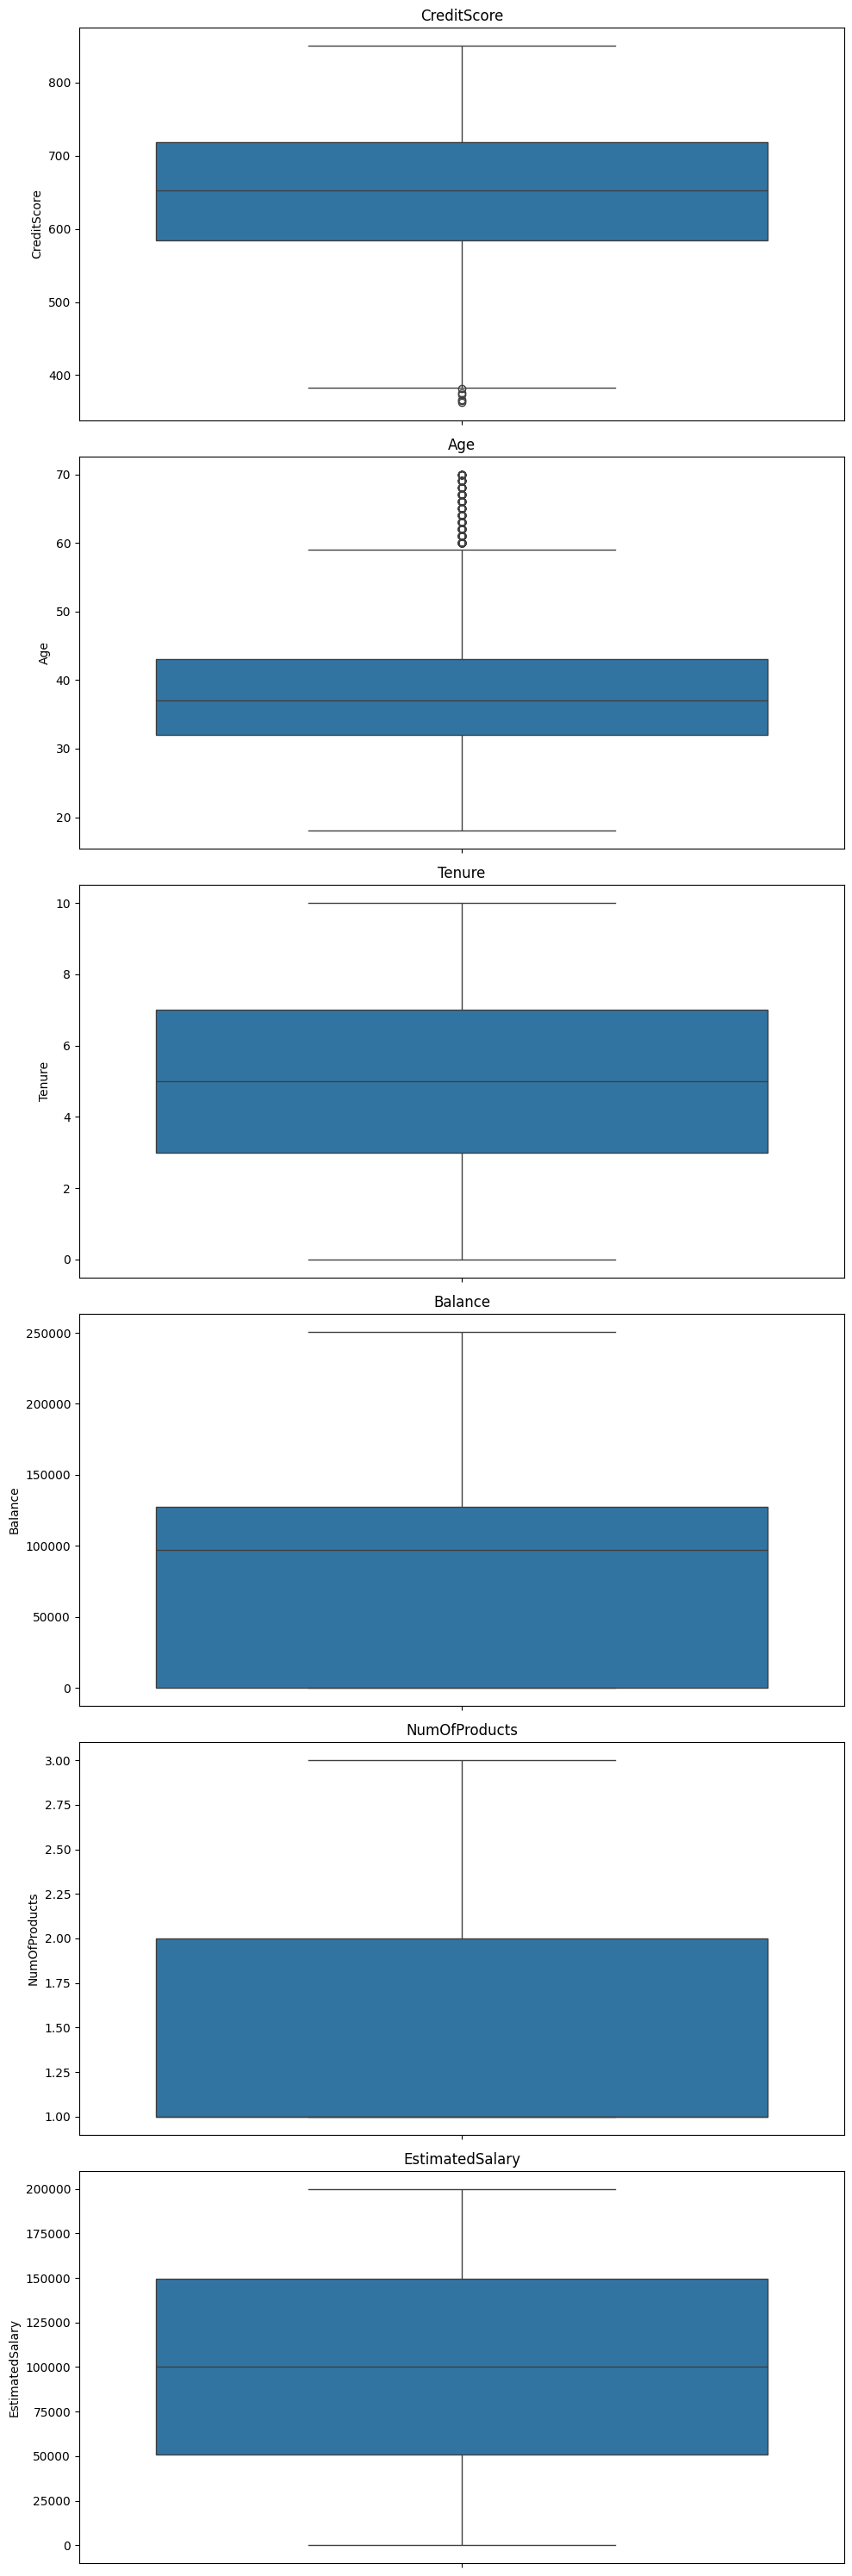

In [8]:
num_cols = len(rest_columns)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))

for i, col in enumerate(rest_columns):
    sns.boxplot(y=X[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')  

plt.tight_layout()

plt.show()

In [9]:
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    ('encoding', OneHotEncoder(sparse_output=False)), 
    ('normalization', StandardScaler()) 
])
rest_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), 
    ('normalization', StandardScaler()) 
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('rest', rest_preprocessor, rest_columns)
])

model = LogisticRegression()

In [10]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [11]:
X = preprocessor.fit_transform(X)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10
0,0.997656,-0.577390,-0.575504,1.099986,-1.099986,-0.327879,0.374169,-1.041776,-1.225443,-0.935749,0.022951
1,-1.002350,-0.577390,1.737607,1.099986,-1.099986,-0.442063,0.270681,-1.387705,0.117543,-0.935749,0.217648
2,0.997656,-0.577390,-0.575504,1.099986,-1.099986,-1.542374,0.374169,1.033798,1.333055,2.694979,0.241807
3,0.997656,-0.577390,-0.575504,1.099986,-1.099986,0.502545,0.063705,-1.387705,-1.225443,0.879615,-0.107887
4,-1.002350,-0.577390,1.737607,1.099986,-1.099986,2.069970,0.477658,-1.041776,0.785816,-0.935749,-0.364310
...,...,...,...,...,...,...,...,...,...,...,...
9794,0.997656,-0.577390,-0.575504,-0.909103,0.909103,1.249926,0.063705,-0.003989,-1.225443,0.879615,-0.065377
9795,0.997656,-0.577390,-0.575504,-0.909103,0.909103,-1.397050,-0.350248,1.725655,-0.306119,-0.935749,0.029054
9796,0.997656,-0.577390,-0.575504,1.099986,-1.099986,0.606348,-0.246760,0.687869,-1.225443,-0.935749,-1.007840
9797,-1.002350,1.731933,-0.575504,-0.909103,0.909103,1.260306,0.374169,-0.695847,-0.022392,0.879615,-0.124204


## 3. Seleção de modelos

### 3.1 Separação em teste e treino

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3.2 Treinamento dos modelos

In [15]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
mac = f1_score(y_test, y_pred)

print(acc, prec, rec, mac)

0.8454081632653061 0.7688442211055276 0.37317073170731707 0.5024630541871922


<Axes: >

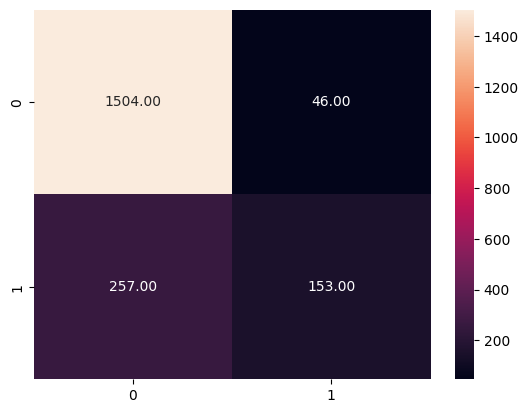

In [17]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="0.2f")

### Random forest com hiperparâmetros

In [19]:
model_rf = RandomForestClassifier()

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=61, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=True, max_depth=61, max_features=auto, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   0.0s
[CV] END bootstrap=False, max_depth=11, max_features=auto, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   0.0s
[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=10, min_samples_split=17, n_estimators=882; total time=   0.0s
[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=10, min_samples_split=17, n_esti

/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
 

In [20]:
y_pred = best_model.predict(X_test)

In [21]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
mac = f1_score(y_test, y_pred)

print(acc, prec, rec, mac)

0.8530612244897959 0.7563025210084033 0.43902439024390244 0.5555555555555556


<Axes: >

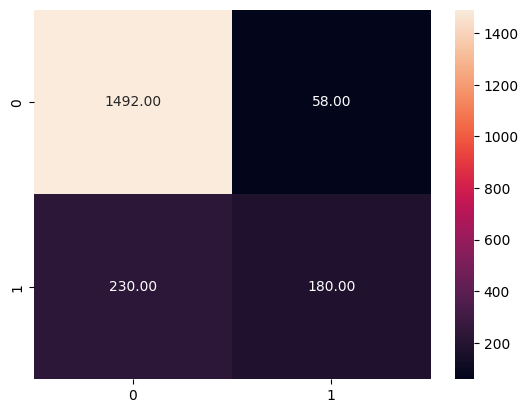

In [22]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="0.2f")

In [28]:
model_svc = SVC()
param_distributions = {
    'C': expon(scale=100), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(expon(scale=0.1).rvs(5)), 
    'degree': randint(2, 6)
}

random_search = RandomizedSearchCV(
    estimator=model_svc,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV] END C=46.92680899768591, degree=2, gamma=0.19459144401767503, kernel=rbf; total time=   2.6s
[CV] END C=16.959629191460518, degree=4, gamma=0.2641843407392776, kernel=sigmoid; total time=   1.7s
[CV] END C=16.959629191460518, degree=4, gamma=0.2641843407392776, kernel=sigmoid; total time=   1.8s
[CV] END C=46.92680899768591, degree=2, gamma=0.19459144401767503, kernel=rbf; total time=   2.9s
[CV] END C=46.92680899768591, degree=2, gamma=0.19459144401767503, kernel=rbf; total time=   3.2s
[CV] END C=16.959629191460518, degree=4, gamma=0.2641843407392776, kernel=sigmoid; total time=   2.0s
[CV] END C=5.806520264207262, degree=5, gamma=0.08776942512443947, kernel=poly; total time=   2.1s
[CV] END C=5.806520264207262, degree=5, gamma=0.08776942512443947, kernel=poly; total time=   2.0s
[CV] END C=5.806520264207262, degree=5, gamma=0.08776942512443947, kernel=poly; total time=   1.8s
[CV] END C=23.8687625248947, degree=5, gamma=0.08776942512443947, kernel=linear; total time=   4.6s
[CV

In [29]:
y_pred = best_model.predict(X_test)

In [30]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
mac = f1_score(y_test, y_pred)

print(acc, prec, rec, mac)

0.8505102040816327 0.7647058823529411 0.4121951219512195 0.5356576862123613


<Axes: >

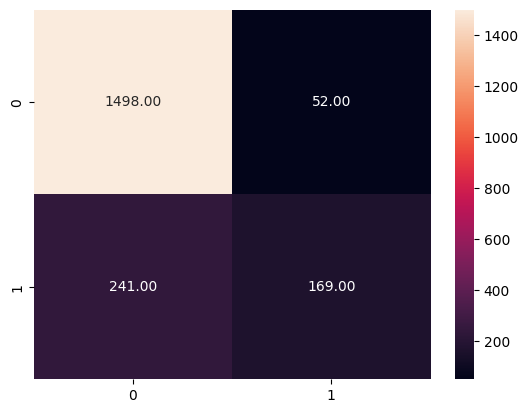

In [31]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="0.2f")

In [41]:
model_xgb = xgb.XGBClassifier(user_label_encoder=False, eval_metric='logloss')

param_distributions = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'colsample_bylevel': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5),                # Regularização L1
    'reg_lambda': uniform(0.5, 1)                # Regularização L2
}

random_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_distributions, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=42)

In [42]:
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "user_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "user_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "user_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clara/miniconda3/envs/avanti/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:23:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "user_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clara/miniconda3/envs/avanti/lib/python3.10/si

In [43]:
y_pred = best_model.predict(X_test)

In [44]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
mac = f1_score(y_test, y_pred)

print(acc, prec, rec, mac)

0.8489795918367347 0.7261904761904762 0.44634146341463415 0.552870090634441


<Axes: >

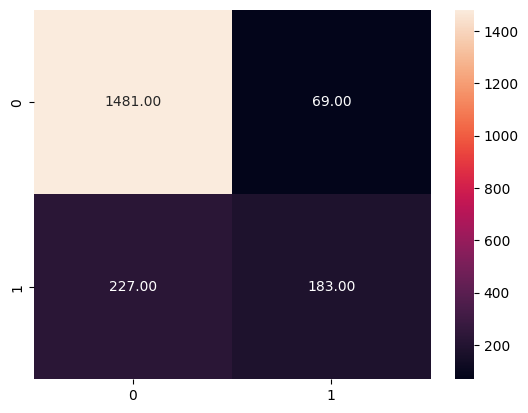

In [45]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, fmt="0.2f")

### 3.3 Persistência do modelo

In [46]:
joblib.dump(best_model, 'model_xgb.pkl')

['model_xgb.pkl']